In [3]:
# !pip install urllib
import requests
from bs4 import BeautifulSoup
import re
import os 
import time
from io import BytesIO
from zipfile import ZipFile
import pandas as pd
import glob
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import csv
import math
import h2o
from sklearn import linear_model
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.feature_selection import f_regression 
from sklearn.svm import LinearSVC
from sklearn.exceptions import NotFittedError
from sklearn.svm import SVR
from itertools import chain, combinations
from sklearn.cross_validation import cross_val_score
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from pybrain.tools.shortcuts import buildNetwork
from pybrain.datasets import SupervisedDataSet
from pybrain.supervised.trainers import BackpropTrainer
from sklearn.preprocessing import MinMaxScaler

C:\Users\khushbu\Anaconda2\lib\site-packages\sklearn\cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [4]:
fileDir = os.path.dirname(os.path.realpath('__file__'))

In [5]:
print(fileDir)

C:\Users\khushbu\Assignments\Ads_MidTerm


In [6]:
baseUrl='https://freddiemac.embs.com/FLoan/'
postUrl='Data/download.php'

In [7]:
def createCredentialData(user, passwd):
    creds={'username': user,'password': passwd}
    return creds

In [8]:
def getFilesFromFreddieMac(cred,quater,year,quaterTwo,yearTwo):
    c=cred
    ## We are using inside WITH BLock so that session is closed ASAP with BLock is exited 
    with requests.Session() as s:
        ## Step 1 routing to auth.php Site with the proper crentials 
        urlOne = s.post(baseUrl+"secure/auth.php", data=cred) 
        if "Please log in" in urlOne.text:
        ## IF CREDENTIALS are not valid Throw Alert 
            print("Alert: Invalid Credentials, Please try again or sign up on below site \n https://freddiemac.embs.com/FLoan/Bin/loginrequest.php")
        else:
            print("Step1: Logged in")
        ## Sterp 2 Preparing the data for to Accept terms and Conditions 
            pay2={'accept': 'Yes','acceptSubmit':'Continue','action':'acceptTandC'}
            finalUrl=s.post(baseUrl +"Data/download.php",pay2)
            if "Loan-Level Dataset" in finalUrl.text:
                      print("Step2 : Terms and Conditions Accepted")
                      soup = BeautifulSoup(finalUrl.content, "html.parser")   
                      links_list = soup.findAll('a')
                      print("Step3: Filtered the Sample Files with Condition =" + year)
                      print("Status::::::::::")
                      for ele in links_list:
        ## Filtering the ZIp files = 2005 
                         if 'historical' in ele.get_text():
                            if(ele.get_text()[-8:-4] == year):
                                    print(ele.get_text()[-8:-4])
                                    if(ele.get_text()[-10:-8] == quater):
                                        print(ele.get_text()[-10:-8])
                                        
                                        tempUrl = baseUrl+"Data/"+ele.get('href')                         
                                        b =time.time()
                                        downloadUrl=s.post(tempUrl) ## return type = Response
                                        e=time.time()
                                        print(tempUrl + " took "+ str(e-b)+" sec")
                                        with ZipFile(BytesIO(downloadUrl.content)) as zfile:
                                              zfile.extractall(os.path.join(fileDir, 'adsDataRepo/'+'Historical_data_'+ele.get_text()[-8:-4]+'/'))
                                              print("File "+ ele.get_text()+" Downloaded")
                            
                            if(ele.get_text()[-8:-4] == yearTwo):
                                    print(ele.get_text()[-8:-4])
                                    if(ele.get_text()[-10:-8] == quaterTwo):
                                        print(ele.get_text()[-10:-8])
                                        
                                        tempUrl = baseUrl+"Data/"+ele.get('href')                         
                                        b =time.time()
                                        downloadUrl=s.post(tempUrl) ## return type = Response
                                        e=time.time()
                                        print(tempUrl + " took "+ str(e-b)+" sec")
                                        with ZipFile(BytesIO(downloadUrl.content)) as zfile:
                                              zfile.extractall(os.path.join(fileDir, 'adsDataRepo/'+'Historical_data_'+ele.get_text()[-8:-4]+'/'))
                                              print("File "+ ele.get_text()+" Downloaded")
                                
                                              
    
            else:
                print("Alert: Please Check the rerouting action suffix")
        
        ##To scrape the data from the Site finalUrl.       
            

In [9]:
def preProcessData(inputQuater,inputYear,inputQuaterTwo,inputYearTwo):
    cleandataOne= ""
    cleandataTwo= ""
    print("pre-process data")
    if(os.path.exists(fileDir+'/adsDataRepo/')):
        trainingDataFile = glob.glob(fileDir+'/adsDataRepo/'+'Historical_data_'+inputYear+'/historical_data1_'+inputQuater+inputYear+'.txt')
        testingDataFile = glob.glob(fileDir+'/adsDataRepo/'+'Historical_data_'+inputYearTwo+'/historical_data1_'+inputQuaterTwo+inputYearTwo+'.txt')
        headerNames = ['CreditScore','FirstPaymentDate','FirstTimeHomeBuyerFlag','MaturityDate','MSA','MIP','NumberOfUnits',
                         'OccupancyStatus','OCLTV','DTI','OriginalUPB','OLTV','OriginalInterestRate','Channel','PrepaymentPenaltyFlag',
                         'ProductType','PropertyState','PropertyType','PostalCode','LoanSequenceNumber','LoanPurpose',
                         'OriginalLoanTerm','NumberOfBorrowers','SellerName','ServicerName','SuperConformingFlag']
        with open(trainingDataFile[0]) as f:
            dataf = pd.read_table(f, sep='|', low_memory=False, header=None,lineterminator='\n', names= headerNames)
            cleandataOne = originationDatacleaning(dataf)
            cleandataOne.to_csv("Origination_Clean_"+inputQuater+inputYear+".csv",index=False)
            print("training data cleaned, CSV Created")
       
        with open(testingDataFile[0]) as f:
            dataf = pd.read_table(f, sep='|', low_memory=False, header=None,lineterminator='\n', names= headerNames)
            cleandataTwo = originationDatacleaning(dataf)
            cleandataTwo.to_csv("Origination_Clean_"+inputQuaterTwo+inputYearTwo+".csv",index=False)
            print("testing data cleaned, CSV Created")

    return cleandataOne,cleandataTwo

In [10]:
def originationDatacleaning(dataf):
    dataf['CreditScore'].replace('   ',301,inplace=True)
    dataf['CreditScore'].fillna(301,inplace=True)
    dataf['FirstTimeHomeBuyerFlag'].fillna('X',inplace=True) 
    dataf['MSA'].replace('   ',0,inplace=True)
    dataf['MSA'].fillna(0, inplace=True) 
    dataf['MIP'].replace('   ',0,inplace=True)
    dataf['MIP'].fillna(0, inplace=True)
    dataf['NumberOfUnits'].fillna(0,inplace=True)
    dataf['OccupancyStatus'].fillna('X',inplace=True)
    dataf['OCLTV'].replace('   ',0,inplace=True)
    dataf['OCLTV'].fillna(0,inplace=True)
    dataf['DTI'].replace('   ',0,inplace=True)
    dataf['DTI'].fillna(0,inplace=True)
    dataf['OriginalUPB'].replace('   ',0,inplace=True)
    dataf['OriginalUPB'].fillna(0,inplace=True)
    dataf['OLTV'].replace('   ',0,inplace=True)
    dataf['OLTV'].fillna(0,inplace=True)
    dataf['OriginalInterestRate'].fillna(0,inplace=True)
    dataf['Channel'].fillna('X',inplace=True)
    dataf['PrepaymentPenaltyFlag'].fillna('X',inplace=True)
    dataf['ProductType'].fillna('XXXXX',inplace=True)
    dataf['PropertyState'].fillna('XX',inplace=True)
    dataf['PropertyType'].fillna('XX',inplace=True)
    dataf['PostalCode'].fillna(0,inplace=True)
    dataf['LoanSequenceNumber'].replace('', np.NaN).fillna(0,inplace=True)
    dataf['LoanPurpose'].fillna('X',inplace=True)
    dataf['OriginalLoanTerm'].replace('', np.NaN).fillna(0,inplace=True)
    dataf['NumberOfBorrowers'].fillna('01',inplace=True)
    dataf['SellerName'].fillna('X',inplace=True)
    dataf['ServicerName'].fillna('X',inplace=True)
    dataf['SuperConformingFlag'].fillna('X',inplace=True)
    
    #factorizing data 
    factorizeCategoricalColumn(dataf)
    
    #assingning datatype
    dataf[['PropertyState','LoanSequenceNumber']]=dataf[['PropertyState','LoanSequenceNumber']].astype('str')
    dataf[['FirstTimeHomeBuyerFlag','OccupancyStatus','Channel','PrepaymentPenaltyFlag','ProductType','PropertyType','CreditScore','LoanPurpose','SellerName','ServicerName','MSA','MIP','NumberOfUnits','DTI','OCLTV','OLTV','PostalCode','NumberOfBorrowers']]=dataf[['FirstTimeHomeBuyerFlag','OccupancyStatus','Channel','PrepaymentPenaltyFlag','ProductType','PropertyType','CreditScore','LoanPurpose','SellerName','ServicerName','MSA','MIP','NumberOfUnits','DTI','OCLTV','OLTV','PostalCode','NumberOfBorrowers']].astype('int64')
    
    #missinganalysis(dataf)
    
    return dataf
    '''As we can see we have the below Null Values presnt in the Data for all the Years (Only varying the Counts )
                       MSA           
    FirstTimeHomeBuyerFlag           
     PrepaymentPenaltyFlag          
         NumberOfBorrowers 
    We can ignore''' 

In [11]:
def selectFeatures(datadfTraining,datadfTesting):
    label=datadfTraining.OriginalInterestRate
    datadfTraining.drop('OriginalInterestRate',axis=1,inplace=True)
    features=datadfTraining
    labelTesting=datadfTesting.OriginalInterestRate
    datadfTesting.drop('OriginalInterestRate',axis=1,inplace=True)
    featuresTesting=datadfTesting
    print("Linear Regression Feature Selection") 
    linearRegressionModel(label,features)
    print("Recursive Feature Elimination Feature Selection")
    recursiveFeatureElimination(label,features)
    print("Select K Best Feature Selection")
    selectKBestFeatures(label,features)
    #stepwiseFeatureSelection(label,features)
    print("lasso LarsRegression Model Feature Selection") 
    lassoLarsRegressionModel(label,features)
    print("Reidge Regression Model Feature Selection") 
    reidgeRegressionModel(label,features)

In [12]:
# linear regression model
def linearRegressionModel(label,features):
    model= linear_model.LinearRegression()
    model.fit(features,label) 
    score=model.score(features,label) 
    pd.DataFrame(list(zip(features.columns,model.coef_)),columns=["features","estimatedCoefficients"])
    print rank_to_dict(np.abs(model.coef_), features)
    prediction=model.predict(features)
    r2Score=r2_score(label,prediction)
    print(r2Score)
    return model

In [13]:
def recursiveFeatureElimination(label,features):
    model= linear_model.LinearRegression()
    rfe = RFE(model, n_features_to_select=4)
    rfe = rfe.fit(features,label)
    print sorted(zip(map(lambda features: round(features, 4), rfe.ranking_), features))
    prediction=rfe.predict(features)
    r2Score=r2_score(label,prediction)
    print(r2Score)
    return rfe

In [14]:
def selectKBestFeatures(label,feature):
    model= linear_model.LinearRegression()
    test = SelectKBest(f_regression,k='all') 
    test.fit(feature, label)
    features = test.transform(feature)
    model.fit(feature, label)
    print rank_to_dict(np.abs(model.coef_), feature)
    prediction=model.predict(feature)
    r2Score=r2_score(label,prediction)
    print(r2Score)
    return model

In [15]:
def stepwiseFeatureSelection(label,features):
    lr = linear_model.LinearRegression()
    sfs = SFS(lr, 
              k_features=1
              )
    sfs = sfs.fit(features, label)
    prediction=sfs.predict(features)
    r2Score=r2_score(label,prediction)
    print(r2Score)
    return sfs


In [16]:
def lassoLarsRegressionModel(label,features):
    clf = linear_model.LassoLars(alpha=0.01)
    clf.fit(features,label)
    print rank_to_dict(np.abs(clf.coef_), features)
    prediction=clf.predict(features)
    r2Score=r2_score(label,prediction)
    print(r2Score)
    return clf

In [17]:
def reidgeRegressionModel(label,features):
    reg = linear_model.Ridge (alpha = .5)
    reg.fit (features,label)
    print rank_to_dict(np.abs(reg.coef_), features)
    prediction=reg.predict(features)
    r2Score=r2_score(label,prediction)
    print(r2Score)
    return reg

In [18]:
def rank_to_dict(ranks, names, order=1):
    minmax = MinMaxScaler()
    ranks = minmax.fit_transform(order*np.array([ranks]).T).T[0]
    ranks = map(lambda x: round(x, 2), ranks)
    return dict(zip(names, ranks ))

In [19]:
def computeMae(model_mae,y,x):
    model= model_mae
    pred=model.predict(x)
    mae=mean_absolute_error(y,pred);
    print("MAE:"+str(mae))

In [20]:
def computeRMSE(model_rmse,y,x):
    model= model_rmse
    pred=model.predict(x)
    rmse=math.sqrt(mean_squared_error(y,pred))
    print("RMSE:"+str(rmse))

In [21]:
def computeMape(model_mape,y,x):
    model= model_mape
    pred=model.predict(x)
    mape=np.mean(np.abs((y - pred) / y)) * 100
    print( "MAPE:"+str(mape))

In [22]:
def randomForestRegressionAlgorithm(datadfTraining,datadfTesting):
    label=datadfTraining.OriginalInterestRate
    datadfTraining.drop('OriginalInterestRate',axis=1,inplace=True)
    features=datadfTraining
    labelTesting=datadfTesting.OriginalInterestRate
    datadfTesting.drop('OriginalInterestRate',axis=1,inplace=True)
    featuresTesting=datadfTesting
    print("Training Data")
    rForest=RandomForestRegressor(max_depth=8)
    rForest.fit(features,label)
    computeMae(rForest,label,features)
    computeRMSE(rForest,label,features)
    computeMape(rForest,label,features)
    print("Testing Data")
    computeMae(rForest,labelTesting,featuresTesting)
    computeRMSE(rForest,labelTesting,featuresTesting)
    computeMape(rForest,labelTesting,featuresTesting)
    plt.scatter(rForest.predict(features),rForest.predict(features)-label,c='r',s=40,alpha=0.5)
    plt.scatter(rForest.predict(featuresTesting),rForest.predict(featuresTesting)-labelTesting,c="b",s=40)
    plt.hlines(y=0,xmin=2,xmax=10)
    plt.title('Residual plot using training(blue) and test(green) data')
    plt.ylabel('Residuals')
    #plt.show()

In [23]:
def neuralNetworkAlgorithm(datadfTraining,datadfTesting):
    print("Executing Neural Network algorithm")
    label=datadfTraining.OriginalInterestRate
    label=label.reshape(-1,1)
    datadfTraining.drop('OriginalInterestRate',axis=1,inplace=True)
    features=datadfTraining
    labelTesting=datadfTesting.OriginalInterestRate
    labelTesting=labelTesting.reshape(-1,1)
    datadfTesting.drop('OriginalInterestRate',axis=1,inplace=True)
    featuresTesting=datadfTesting
    
    print("Training Data")
    hidden_size = 3
    epochs = 2
    input_size = features.shape[1]
    target_size = label.shape[1]
    ds = SupervisedDataSet( input_size, target_size )
    ds.setField( 'input', features)
    ds.setField( 'target', label)

    net = buildNetwork( input_size, hidden_size, target_size, bias = True )
    trainer = BackpropTrainer( net,ds )

    print("Training for {} epochs...".format( epochs ))

    for i in range( epochs ):
        mse = trainer.train()
        rmse = math.sqrt( mse )
    print("Training RMSE, epoch {}: {}".format( i + 1, rmse ))


    input_size = featuresTesting.shape[1]
    target_size = labelTesting.shape[1]

    ds = SupervisedDataSet( input_size, target_size )
    ds.setField( 'input', featuresTesting)
    ds.setField( 'target', labelTesting)

    p = net.activateOnDataset( ds )

    mse = mean_squared_error(labelTesting, p )
    rmse =math.sqrt(mse)
    print("Testing rmse:"+str(rmse))

In [24]:
def h20Algorithm(inputQuater,inputYear,inputQuaterTwo,inputYearTwo):
    h2o.init()
    trainingData = h2o.import_file("Origination_Clean_"+inputQuater+inputYear+".csv")
    testingData = h2o.import_file("Origination_Clean_"+inputQuaterTwo+inputYearTwo+".csv")
    y = "OriginalInterestRate"
    x = ['CreditScore','OriginalLoanTerm','OriginalUPB','DTI']
    model = h2o.estimators.deeplearning.H2ODeepLearningEstimator()
    model.train(x, y, trainingData)
    p = model.predict(testingData)
    #m.model_performance(testH2OData)
    performance = model.model_performance(testingData)
    mse = model.mse(performance)
    rmse = model.rmse(performance)
    mae = model.mae(performance)
    #return (m.model_performance(testH2OData))
    print("MSE :"+ str(mse))
    print("RMSE :"+ str(rmse))
    print("MAE :"+ str(mae))

In [25]:
def KNNAlgorithm(datadfTraining,datadfTesting):
    print("Executing KNN algorithm")
    label=datadfTraining.OriginalInterestRate
    datadfTraining.drop('OriginalInterestRate',axis=1,inplace=True)
    features=datadfTraining
    labelTesting=datadfTesting.OriginalInterestRate
    datadfTesting.drop('OriginalInterestRate',axis=1,inplace=True)
    featuresTesting=datadfTesting
    print("Training Data")
    kNeighbour = KNeighborsRegressor(n_neighbors=6)
    kNeighbour.fit(features,label) 
    computeMae(kNeighbour,label,features)
    computeRMSE(kNeighbour,label,features)
    computeMape(kNeighbour,label,features)
    print("Testing Data")
    computeMae(kNeighbour,labelTesting,featuresTesting)
    computeRMSE(kNeighbour,labelTesting,featuresTesting)
    computeMape(kNeighbour,labelTesting,featuresTesting)
    plt.scatter(kNeighbour.predict(features),kNeighbour.predict(features)-label,c='r',s=40,alpha=0.5)
    plt.scatter(kNeighbour.predict(featuresTesting),kNeighbour.predict(featuresTesting)-labelTesting,c="b",s=40)
    plt.hlines(y=0,xmin=2,xmax=10)
    plt.title('Residual plot using training(blue) and test(green) data')
    plt.ylabel('Residuals')
    #plt.show()

In [32]:
def factorizeCategoricalColumn(cleanperfTrain):
        print('_________________________________________________________')
        print('Factorizing the Categorical Columns .....................')
        print('_________________________________________________________')

        cleanperfTrain['FirstTimeHomeBuyerFlag'] = pd.factorize(cleanperfTrain['FirstTimeHomeBuyerFlag'])[0]
        cleanperfTrain['OccupancyStatus'] = pd.factorize(cleanperfTrain['OccupancyStatus'])[0]
        cleanperfTrain['Channel'] = pd.factorize(cleanperfTrain['Channel'])[0]
        cleanperfTrain['ProductType'] = pd.factorize(cleanperfTrain['ProductType'])[0]
        cleanperfTrain['PropertyType'] = pd.factorize(cleanperfTrain['PropertyType'])[0]
        cleanperfTrain['LoanPurpose'] = pd.factorize(cleanperfTrain['LoanPurpose'])[0]
        cleanperfTrain['SellerName'] = pd.factorize(cleanperfTrain['SellerName'])[0]
        cleanperfTrain['ServicerName'] = pd.factorize(cleanperfTrain['ServicerName'])[0]
        cleanperfTrain['PrepaymentPenaltyFlag'] = pd.factorize(cleanperfTrain['PrepaymentPenaltyFlag'])[0]
        
        return cleanperfTrain

In [33]:
def dropColumns(file):
    file.drop("FirstPaymentDate",axis=1,inplace=True)
    file.drop("MaturityDate",axis=1,inplace=True)
    file.drop("PostalCode",axis=1,inplace=True)

In [90]:
def reducedColumnsAnalysis(datadf):
    #datadf.drop('FirstTimeHomeBuyerFlag',axis=1,inplace=True)
    #datadf.drop('DTI',axis=1,inplace=True)
    #datadf.drop('OCLTV',axis=1,inplace=True)
    #datadf.drop('NumberOfBorrowers',axis=1,inplace=True)
    #datadf.drop('PropertyType',axis=1,inplace=True)
    #datadf.drop('MSA',axis=1,inplace=True)
    #datadf.drop('PrepaymentPenaltyFlag',axis=1,inplace=True)
    #datadf.drop('OLTV',axis=1,inplace=True)
    datadf.drop('OccupancyStatus',axis=1,inplace=True)
    #datadf.drop('NumberOfUnits',axis=1,inplace=True)
    #datadf.drop('ProductType',axis=1,inplace=True)
    #datadf.drop('ServicerName',axis=1,inplace=True)
    datadf.drop('SellerName',axis=1,inplace=True)
    #datadf.drop('LoanPurpose',axis=1,inplace=True)
    #datadf.drop('Channel',axis=1,inplace=True)
    #datadf.drop('OriginalUPB',axis=1,inplace=True)
    label_datadfTraining_reduced= datadf.OriginalInterestRate
    datadf.drop('OriginalInterestRate',axis=1,inplace=True)
    features_reduced=datadf
    linearRegressionModel(label_datadfTraining_reduced,features_reduced)
    

In [103]:
def LinearRegressionAnalysis(datadfTraining,datadfTesting):
    label=datadfTraining.OriginalInterestRate
    datadfTraining.drop('OriginalInterestRate',axis=1,inplace=True)
    features=datadfTraining
    labelTesting=datadfTesting.OriginalInterestRate
    datadfTesting.drop('OriginalInterestRate',axis=1,inplace=True)
    featuresTesting=datadfTesting    
    m1=linearRegressionModel(label,features) 
    print("Training Data")
    computeMae(m1,label,features)
    computeRMSE(m1,label,features)
    computeMape(m1,label,features)
    print("Testing Data:")
    computeMae(m1,labelTesting,featuresTesting)
    computeRMSE(m1,labelTesting,featuresTesting)
    computeMape(m1,labelTesting,featuresTesting)
    plt.scatter(m1.predict(features),m1.predict(features)-label,c='b',s=40,alpha=0.5)
    plt.scatter(m1.predict(featuresTesting),m1.predict(featuresTesting)-labelTesting,c="r",s=40)
    plt.hlines(y=0,xmin=2,xmax=10)
    plt.title('Residual plot using training(blue) and test(red) data')
    plt.ylabel('Residuals')

Enter QuaterQ1
Enter year2005
pre-process data
_________________________________________________________
Factorizing the Categorical Columns .....................
_________________________________________________________
training data cleaned, CSV Created
_________________________________________________________
Factorizing the Categorical Columns .....................
_________________________________________________________
testing data cleaned, CSV Created
Linear Regression Feature Selection
{'FirstTimeHomeBuyerFlag': 0.19, 'DTI': 0.0, 'OriginalUPB': 0.0, 'ServicerName': 0.02, 'SellerName': 0.02, 'OCLTV': 0.01, 'NumberOfBorrowers': 0.18, 'OccupancyStatus': 1.0, 'PropertyType': 0.12, 'CreditScore': 0.01, 'LoanPurpose': 0.28, 'NumberOfUnits': 0.32, 'Channel': 0.53, 'ProductType': 0.0, 'OLTV': 0.0, 'MIP': 0.03, 'OriginalLoanTerm': 0.02, 'MSA': 0.0, 'PrepaymentPenaltyFlag': 0.88}
0.388428757513
Recursive Feature Elimination Feature Selection
[(1.0, 'NumberOfBorrowers'), (1.0, 'Occupancy

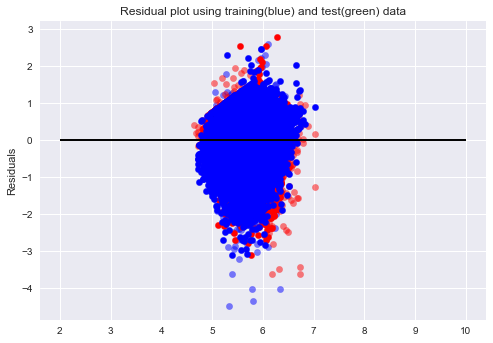

Training Data
MAE:0.201749223251
RMSE:0.273223146225
MAPE:3.57058402688
Testing Data
MAE:0.245227552593
RMSE:0.320189636659
MAPE:4.19221236031


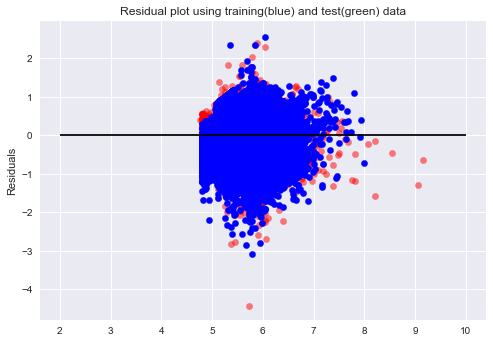

Executing Neural Network algorithm


C:\Users\khushbu\Anaconda2\lib\site-packages\ipykernel_launcher.py:4: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  after removing the cwd from sys.path.
C:\Users\khushbu\Anaconda2\lib\site-packages\ipykernel_launcher.py:8: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  


Training Data
Training for 2 epochs...
Training RMSE, epoch 2: 0.262767734451
Testing rmse:0.363770704555
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.131-b11, mixed mode)
  Starting server from C:\Users\khushbu\Anaconda2\lib\site-packages\h2o\backend\bin\h2o.jar
  Ice root: c:\users\khushbu\appdata\local\temp\tmpnv2feg
  JVM stdout: c:\users\khushbu\appdata\local\temp\tmpnv2feg\h2o_khushbu_started_from_python.out
  JVM stderr: c:\users\khushbu\appdata\local\temp\tmpnv2feg\h2o_khushbu_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321... successful.


H2O cluster uptime:,06 secs
H2O cluster version:,3.10.4.8
H2O cluster version age:,2 months
H2O cluster name:,H2O_from_python_khushbu_8pcyy7
H2O cluster total nodes:,1
H2O cluster free memory:,1.759 Gb
H2O cluster total cores:,4
H2O cluster allowed cores:,4
H2O cluster status:,"accepting new members, healthy"
H2O connection url:,http://127.0.0.1:54321
H2O connection proxy:,None


Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
deeplearning Model Build progress: |██████████████████████████████████████| 100%
deeplearning prediction progress: |███████████████████████████████████████| 100%
MSE :0.0883594390014
RMSE :0.29725315642
MAE :0.219430410094


In [105]:
def main():
    creds=createCredentialData("parekh.kh@husky.neu.edu","UkQqsHbV")
    inputQuater= raw_input('Enter Quater')
    inputYear= raw_input('Enter year')
    #getFilesFromFreddieMac(creds,inputQuater,inputYear)
    if(int(inputQuater[1:2])<4):
        temp = int(inputQuater[1:2])
        temp += 1
        t=str(temp)
        newQuater="Q"+t
        inputQuaterTwo=newQuater
        getFilesFromFreddieMac(creds,inputQuater,inputYear,inputQuaterTwo,inputYear)
        files=preProcessData(inputQuater,inputYear,inputQuaterTwo,inputYear)
        dropColumns(files[0])
        dropColumns(files[1])
        selectFeatures(files[0]._get_numeric_data(),files[1]._get_numeric_data())
        reducedColumnsAnalysis(files[0]._get_numeric_data())
        LinearRegressionAnalysis(files[0]._get_numeric_data(),files[1]._get_numeric_data())
        KNNAlgorithm(files[0]._get_numeric_data(),files[1]._get_numeric_data())
        randomForestRegressionAlgorithm(files[0]._get_numeric_data(),files[1]._get_numeric_data())
        neuralNetworkAlgorithm(files[0]._get_numeric_data(),files[1]._get_numeric_data())
        h20Algorithm(inputQuater,inputYear,inputQuaterTwo,inputYear)
        
    else:
        year = int(inputYear)+1
        inputYearTwo=str(year)
        inputQuaterTwo="Q1"
        getFilesFromFreddieMac(creds,inputQuater,inputYear,inputQuaterTwo,inputYearTwo)
        files=preProcessData(inputQuater,inputYear,inputQuaterTwo,inputYearTwo)
        dropColumns(files[0])
        dropColumns(files[1])
        selectFeatures(files[0]._get_numeric_data(),files[1]._get_numeric_data())
        LinearRegressionAnalysis(files[0]._get_numeric_data(),files[1]._get_numeric_data())
        KNNAlgorithm(files[0]._get_numeric_data(),files[1]._get_numeric_data())
        randomForestRegressionAlgorithm(files[0]._get_numeric_data(),files[1]._get_numeric_data())
        neuralNetworkAlgorithm(files[0]._get_numeric_data(),files[1]._get_numeric_data())
        h20Algorithm(inputQuater,inputYear,inputQuaterTwo,inputYearTwo)
        
    
        
if __name__ == '__main__':
    main()        